# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [ ]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

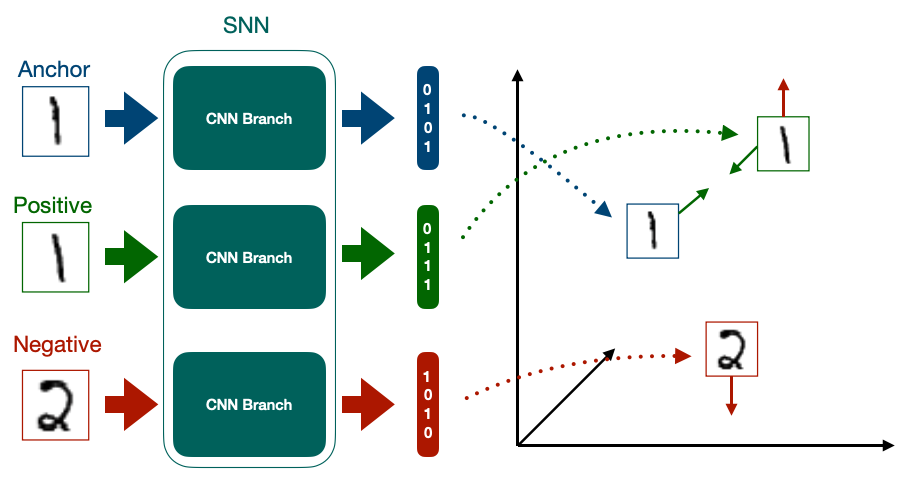

# Imports

In [1]:
import sys
sys.path.append('D:\Desktop\Siamese Network\Siamese-Network\Dataset')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

# Configurations

In [10]:
DATA_DIR = 'D:/Desktop/Siamese Network/Siamese-Network/Dataset/train'
CSV_FILE = 'D:/Desktop/Siamese Network/Siamese-Network/Dataset/train.csv'

BATCH_SIZE = 32
LR = 0.001
EPOCHS = 15

DEVICE = 'cpu'

In [11]:
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [31]:
import cv2

row = df.iloc[7]
A_img = cv2.imread(DATA_DIR + '/' + row.Anchor)
A_img = cv2.cvtColor(A_img, cv2.COLOR_BGR2RGB)
P_img = cv2.imread(DATA_DIR + '/' + row.Positive)
P_img = cv2.cvtColor(P_img, cv2.COLOR_BGR2RGB)  
N_img = cv2.imread(DATA_DIR + '/' + row.Negative)
N_img = cv2.cvtColor(N_img, cv2.COLOR_BGR2RGB)

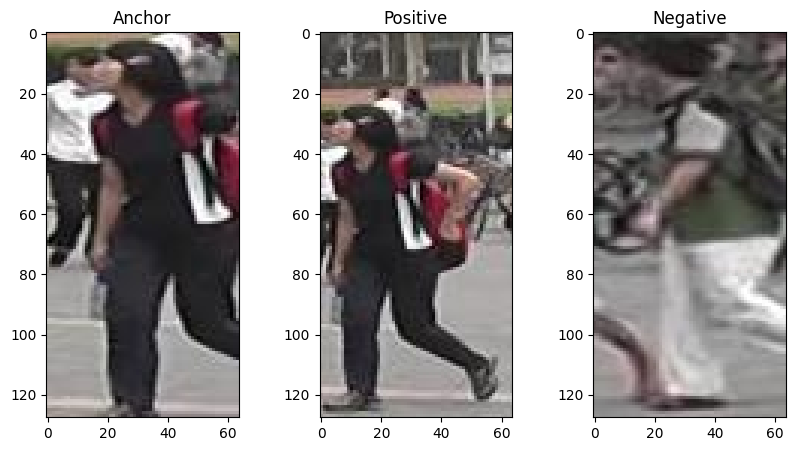

In [32]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10,5))

ax1.set_title('Anchor')
ax1.imshow(A_img)

ax2.set_title('Positive')
ax2.imshow(P_img)

ax3.set_title('Negative')
ax3.imshow(N_img)

In [33]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

# Create APN Dataset

In [34]:
class APN_Dataset(Dataset):
	def __init__(self,df):
		self.df =df
	def __len__(self):
		return len(self.df)
	def __getitem__(self, idx):
		row = self.df.iloc[idx]
		A_img = cv2.imread(DATA_DIR + '/' + row.Anchor)
		A_img = cv2.cvtColor(A_img, cv2.COLOR_BGR2RGB)
		P_img = cv2.imread(DATA_DIR + '/' + row.Positive)
		P_img = cv2.cvtColor(P_img, cv2.COLOR_BGR2RGB)
		N_img = cv2.imread(DATA_DIR + '/' + row.Negative)
		N_img = cv2.cvtColor(N_img, cv2.COLOR_BGR2RGB)

		A_img = torch.from_numpy(A_img).permute(2, 0, 1)/255.0
		P_img = torch.from_numpy(P_img).permute(2, 0, 1)/255.0
		N_img = torch.from_numpy(N_img).permute(2, 0, 1)/255.0

		return A_img, P_img, N_img

In [35]:
train_set = APN_Dataset(train_df)
valid_set = APN_Dataset(valid_df)

print(f"size of training set: {len(train_set)}")
print(f"size of validation set: {len(valid_set)}")

size of training set: 3200
size of validation set: 800


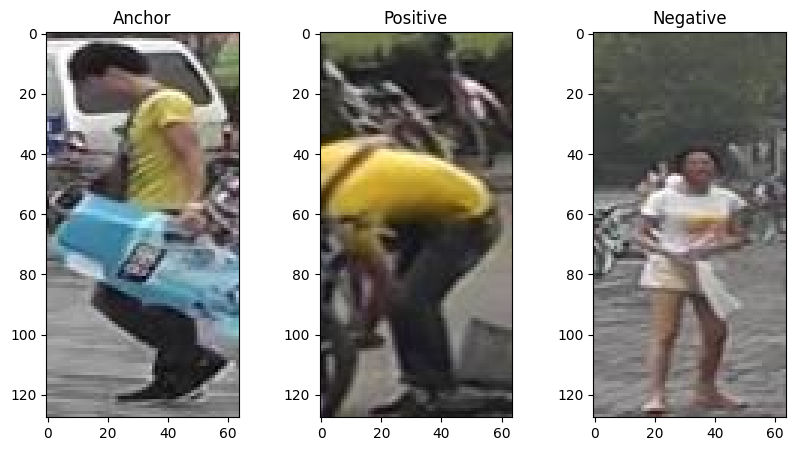

In [37]:
idx = 40
A,P,N = train_set[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [38]:
trainloader = DataLoader(train_set, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(valid_set, batch_size = BATCH_SIZE)

In [39]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [41]:
for A, P, N in trainloader:
	break

print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model

In [45]:
class APN_Model(nn.Module):
   
	def __init__(self, emb_size = 512):
		super(APN_Model, self).__init__()
		self.efficientnet = timm.create_model('efficientnet_b0', pretrained = True)
		self.efficientnet.classifier = nn.Linear(in_features = self.efficientnet.classifier.in_features, out_features = emb_size)

	def forward(self, images):
		embeddings = self.efficientnet(images)
		return embeddings 

In [47]:
model = APN_Model()
model.to(DEVICE)

APN_Model(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw):

# Create Train and Eval function

In [ ]:
def train_fn(model, dataloader, optimizer, criterion):
	model.train()
	total_loss = 0.0
   
	for A, P, N in tqdm(dataloader):
		A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

		A_embs = model(A)
		P_embs = model(P)
		N_embs = model(N)

		loss = criterion(A_embs, P_embs, N_embs)

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		

# Create Training Loop

# Get Anchor Embeddings

# Inference

In [ ]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 5);